# Практическое задание к уроку 6. Metric learning

Обучить сиамскую сеть для верификации лиц на датасете LFW (Labelled Faces in the Wild)

Библиотеки: [Python, Tensorflow]

Полезные ссылки:
- https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
- https://scikit-learn.org/0.15/datasets/labeled_faces.html
- https://www.kaggle.com/paoloripamonti/face-recogniton
- https://www.kaggle.com/jessicali9530/lfw-dataset/code?datasetId=26922&sortBy=voteCount
- https://scikit-learn.org/stable/datasets/real_world.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tarfile
import pathlib

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [2]:
if 1:
    dataset_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"

    data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                    fname='lfw',
                                    untar=True )

    data_dir = pathlib.Path(data_dir)
else: 
    data_dir = pathlib.Path('lfw')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

13233


In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 10587 files for training.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 2646 files for validation.


In [7]:
len(train_ds), len(test_ds)

(331, 83)

## Визуализация датасета

In [8]:
class_names = train_ds.class_names
print(class_names[:20])

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi']


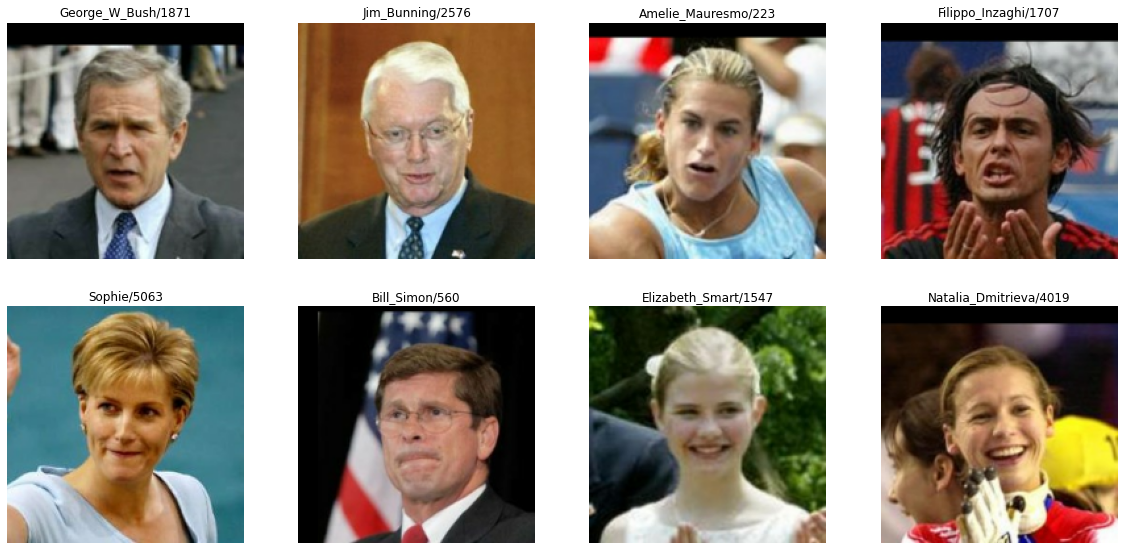

In [9]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'{class_names[labels[i]]}/{labels[i]}')
    plt.axis("off")

## Создание модели CNN

In [10]:
# размерность эмбединга
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # ставим дропаут для избавления от переобучения
    tf.keras.layers.Dropout(0.5),
    # нам нужно не распределение по классам, а некий вектор без активации
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

Contrastive loss определяется для пары объектов. Нам важно определить семантическую близость (или далёкость) объектов.
Цель - если объекты близки (похожи, из одного класса) - приближать их векторы, если это разные классы - удалять.

В Contrastiv loss используется Евклидово расстояние.

In [11]:
MARGIN = 10.0 # MARGIN - условное расстояние, на которое нужно разнести наши классы в embeding-пространстве

def contastive_loss(embs, labels):
    try: 
        # приходит батч эмбедингов и метки
        bs = embs.shape[0]
        # разбиваем батч эмбедингов по парам
        embs1 = embs[:bs//2, :]
        embs2 = embs[bs//2:, :]
        # разбиваем лейблы по парам
        labels1 = labels[:bs//2]
        labels2 = labels[bs//2:]
        # вычитаем вторые эмбединги из первых. получаем 32 разницы веторов, поэлементно возводим в квадрат
        # и суммируем вдоль первого измерения (нулевое батч-измерение оставляем как есть)
        d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
        # извлекаем квадратный корень и получаем батч из 32-х расстояний
        d =  tf.sqrt(d2)
        # индикатор того близки два объекта или далеки. labels1 == labels2 - это список из 32 булевых значений
        # получим там где класс одинаковый - 1, где разные - 0
        z = tf.cast(labels1 == labels2, tf.float32)
        # вычисляем контрастив лосс
    except Exception as ex:
        print('>',embs1)
        print('>',embs2)
        print(ex)
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка к обучению

In [12]:
BATCH_SIZE = 32
NUM_EPOCHS = 7

LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [13]:
%%time

for epoch in range(NUM_EPOCHS):
    for iteration, (images, labels) in enumerate(train_ds): # labels - это номера классов 0, 1, 2, 3 ...
        if(len(labels)%2 > 0): # на последней операции в эпохе возникает ошибка из-за того что к-во элементов в батче не четное 
                labels = labels[:-1]
                images = images[:-1]
        # Forward
        with tf.GradientTape() as tape:
            embs = model(images) # получаем эмбединги для 64 картинок
            loss_value = contastive_loss(embs, labels) # получаем лосс
            
        # Backward
        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))

        if iteration % 100 == 0:
            print('[{}/{}] Loss: {}'.format(epoch, iteration, loss_value.numpy()))

[0/0] Loss: 85.96929931640625
[0/100] Loss: 0.0
[0/200] Loss: 0.0
[0/300] Loss: 0.0
[1/0] Loss: 0.0
[1/100] Loss: 0.0
[1/200] Loss: 0.0
[1/300] Loss: 0.0
[2/0] Loss: 0.0
[2/100] Loss: 0.00807858444750309
[2/200] Loss: 0.13922226428985596
[2/300] Loss: 0.0
[3/0] Loss: 0.0
[3/100] Loss: 0.0
[3/200] Loss: 0.9979442358016968
[3/300] Loss: 0.0
[4/0] Loss: 0.6643341779708862
[4/100] Loss: 0.0
[4/200] Loss: 0.11101757735013962
[4/300] Loss: 0.0
[5/0] Loss: 0.08458077907562256
[5/100] Loss: 0.00018794508650898933
[5/200] Loss: 0.5122107863426208
[5/300] Loss: 0.6906228065490723
[6/0] Loss: 0.0
[6/100] Loss: 0.0
[6/200] Loss: 0.1428522765636444
[6/300] Loss: 0.0
CPU times: user 3min 19s, sys: 11 s, total: 3min 30s
Wall time: 2min 59s


In [14]:
# посмотрим имена
class_names = train_ds.class_names
print(class_names[:10])

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban']


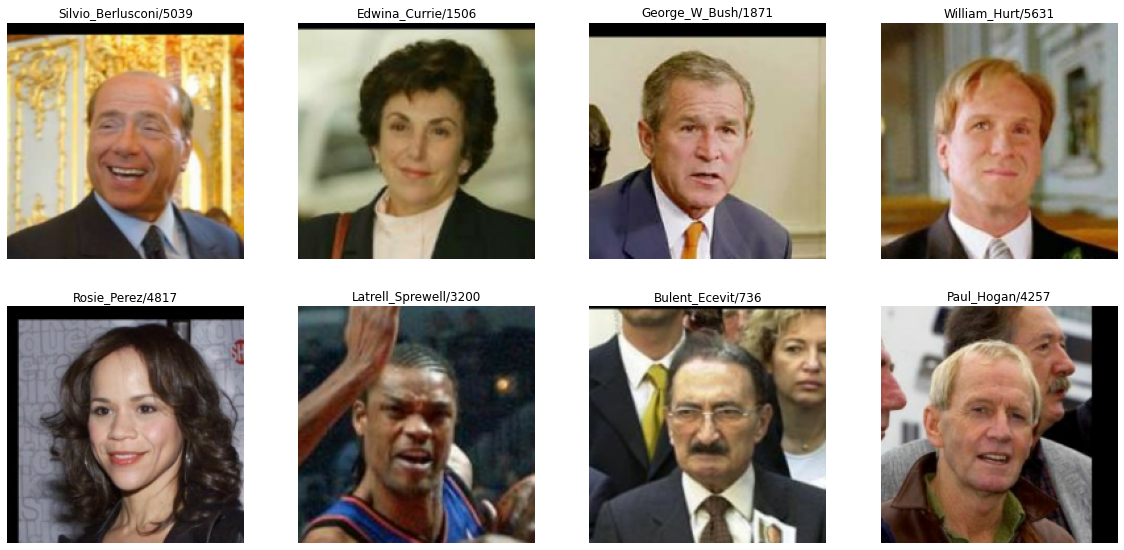

In [15]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'{class_names[labels[i]]}/{labels[i]}')
    plt.axis("off")

In [16]:
person_emb_train = model.predict(train_ds)

## Получение эмбеддингов для тестовой выборки

In [17]:
images, labels = next(iter(test_ds))

In [18]:
%%time

test_imgs=[]
test_labels = []
test_embs = []
for iteration, (images, labels) in enumerate(test_ds):
    for label in labels.numpy():
        test_labels.append(label) 
    embs = model(images)
    for emb in embs.numpy():
        test_embs.append(emb)
test_labels = np.array(test_labels)
test_embs = np.array(test_embs)

CPU times: user 5.08 s, sys: 368 ms, total: 5.44 s
Wall time: 3.1 s


In [29]:
test_lbl_count = {}
for i in test_labels:
    name = class_names[i]
    if name in test_lbl_count:
        test_lbl_count[name] += 1
    else:
        test_lbl_count[name] = 1

In [30]:
test_lbl_count = list(test_lbl_count.items())
test_lbl_count = sorted(test_lbl_count, key=lambda x:x[1], reverse=True)
top_10 = test_lbl_count[:10]
top_10

[('George_W_Bush', 121),
 ('Colin_Powell', 50),
 ('Tony_Blair', 32),
 ('Donald_Rumsfeld', 29),
 ('Gerhard_Schroeder', 23),
 ('Junichiro_Koizumi', 19),
 ('Hugo_Chavez', 14),
 ('Jean_Chretien', 13),
 ('Serena_Williams', 12),
 ('Lleyton_Hewitt', 12)]

## Тестирование на новых данных

In [31]:
images, labels = next(iter(test_ds))

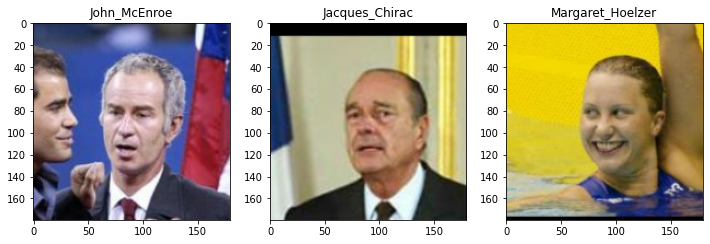

In [32]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
for i in range(3):
    ax[i].imshow(images[i].numpy().astype("uint8"))
    ax[i].set_title(class_names[labels[i].numpy()])
plt.show()

## Получение эмбеддингов для новых данных

In [33]:
new_embs = model(np.stack(images[:3], axis=0))

## Вычисление расстояний между эмбеддингами

In [34]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  22.175447871040845
A2 <-> B1:  24.863709307489575
A1 <-> B1:  32.73082095861636


## Функция для визуализации эмбеддингов

Тяжело смотреть 64-мерное пространство. Используем T-SNE с таким свойством, что близкие объекты в 64-мерном пространстве окажутся рядом в двумерном пространстве и наоборот. Т.е. это тоже в нектором роде эмбединг, но не смысловой, а геометрический.

In [35]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(20, 20))
    for class_idx in targets:
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

## Визуализация образцов LFW в 2D пространстве с помощью TSNE

Сначала визуализируем исходные картинки чтобы посмотреть как они располагаются.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


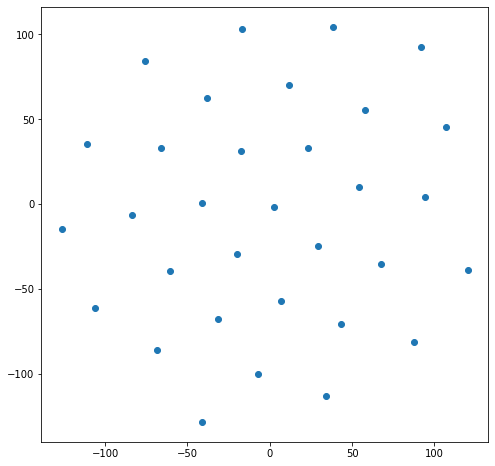

In [36]:
ds = test_ds.take(1)

fig = plt.figure(figsize=(8, 8))

for images, labels in tfds.as_numpy(ds):
    test_embs = model(images)
    # print(labels)
    test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
    plt.scatter(test_embs_2D[:,0], test_embs_2D[:,1])
plt.show()